In [2]:
import json
import pathlib
from itertools import islice
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [4]:
device

'cuda:0'

## Create and load dataset

**Note that there are 533581 examples in our dataset**

In [5]:
class YelpDataset(torch.utils.data.Dataset):
    """Yelp reviews dataset (533581 reviews)"""

    def __init__(self, json_file='../../yelp_review_training_dataset.jsonl', transform=None):
        """
        Args:
            json_file (string): Path to the json file for dataset
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        with open(json_file, 'r') as f:
            self.data = [json.loads(line) for line in f]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        text, review = self.data[idx]['text'], int(self.data[idx]['stars'])
        sample = (text, review - 1) # subtract one so that one-hot label is in [0, 4]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [6]:
data = YelpDataset()

Text(0.5, 1.0, 'length distribution in training dataset')

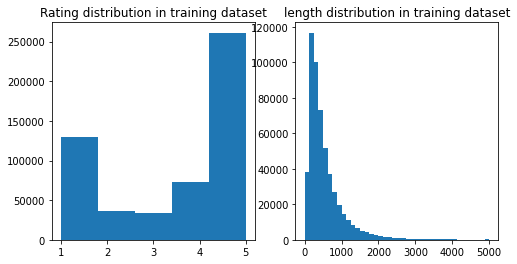

In [7]:
plt.figure(figsize=(8, 4))

ratings = [pair[1]+1 for pair in data]
lengths = [len(pair[0]) for pair in data]

plt.subplot(1, 2, 1)
_ = plt.hist(ratings, bins=5)
plt.title("Rating distribution in training dataset")

plt.subplot(1, 2, 2)
_ = plt.hist(lengths, bins=40)
plt.title("length distribution in training dataset")

In [8]:
challengedata5 = YelpDataset(json_file="../yelp_challenge_5_with_answers.jsonl")

Text(0.5, 1.0, 'length distribution in training dataset')

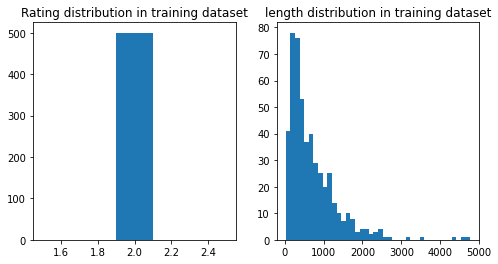

In [9]:
plt.figure(figsize=(8, 4))

ratings = [pair[1]+1 for pair in challengedata5]
lengths = [len(pair[0]) for pair in challengedata5]

plt.subplot(1, 2, 1)
_ = plt.hist(ratings, bins=5)
plt.title("Rating distribution in training dataset")

plt.subplot(1, 2, 2)
_ = plt.hist(lengths, bins=40)
plt.title("length distribution in training dataset")

In [10]:
challengedata8 = YelpDataset(json_file="../yelp_challenge_8_with_answers.jsonl")

Text(0.5, 1.0, 'length distribution in training dataset')

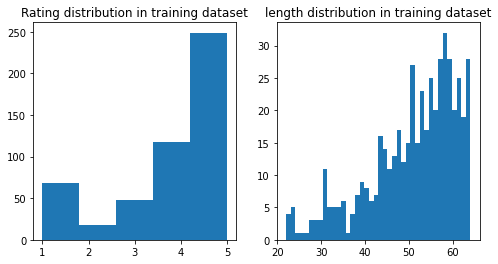

In [11]:
plt.figure(figsize=(8, 4))

ratings = [pair[1]+1 for pair in challengedata8]
lengths = [len(pair[0]) for pair in challengedata8]

plt.subplot(1, 2, 1)
_ = plt.hist(ratings, bins=5)
plt.title("Rating distribution in training dataset")

plt.subplot(1, 2, 2)
_ = plt.hist(lengths, bins=40)
plt.title("length distribution in training dataset")

We have a problem here -- our dataset is very unbalanced. Only about a quarter of it is ratings which are not 1 or 5 stars. So to mitigate this bias, we need to somehow sample from our dataset in a way which balances out the ratings. 

## Created balanced data loaders

In [12]:
ratings = [pair[1]+1 for pair in data]
class_sample_count, _ = np.histogram(ratings, bins=5)
dist = (1 / class_sample_count)

In [13]:
train = torch.utils.data.Subset(data, range(400000))
train_weights = [dist[cat] for (text, cat) in train]
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_weights, num_samples=len(train), replacement=False)
train_loader = torch.utils.data.DataLoader(train, batch_size=10, sampler=train_sampler)

In [14]:
val = torch.utils.data.Subset(data, range(400000, 480000))
val_weights = [dist[cat] for (text, cat) in val]
val_sampler = torch.utils.data.sampler.WeightedRandomSampler(val_weights, num_samples=len(val), replacement=False)
val_loader = torch.utils.data.DataLoader(val, batch_size=10, sampler=val_sampler)

In [15]:
test = torch.utils.data.Subset(data, range(480000, len(data)))
test_weights = [dist[cat] for (text, cat) in test]
test_sampler = torch.utils.data.sampler.WeightedRandomSampler(test_weights, num_samples=len(test), replacement=False)
test_loader = torch.utils.data.DataLoader(val, batch_size=10, sampler=test_sampler)

In [15]:
text, ratings = next(iter(train_loader))

# exp01 -  First do linear classifier on BERT hidden state

## Load up tokenizer and model

In [27]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased').to(device)
model.classifier = nn.Sequential(
    nn.Linear(in_features=768, out_features=5, bias=True),
).to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

## Train the classifier

In [28]:
from transformers import AdamW

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

In [30]:
def expected_rating(logits):
    """Computes expected rating from logits \in [1, 5]"""
    probs = torch.softmax(logits, dim=1)
    return torch.matmul(probs, torch.tensor([1., 2., 3., 4., 5.]).to(device))

### Let's start with 1 epoch

In [31]:
num_batches = []
val_accuracies = []
val_losses = []
val_errors = []

In [33]:
batches = 40000

model.train()
for i, (reviews, classes) in enumerate(tqdm(islice(train_loader, batches), total=batches)): # use the term 'class' instead of 'rating' to denote that class = rating - 1
    
    if i % (batches // 30) == 0: # do 30 val acc computations
        model.eval()
        val_loss = 0
        val_accuracy = 0
        val_error = 0
        outof = 0
        with torch.no_grad():
            for reviews, classes in islice(val_loader, 150): # 150 * batch_size examples to evaluate on
                inputs = tokenizer(reviews, return_tensors="pt", padding=True, truncation=True)
                logits = model(**inputs.to(device)).logits
                _, pred = torch.max(logits, 1)
                val_accuracy += (pred == classes.to(device)).sum().item()
                val_loss += loss_fn(logits, classes.to(device))
                val_error += ((classes.to(device) + 1) - expected_rating(logits)).abs().sum()
                outof += len(classes)
        print("Val Acc: {:.2f}%".format(val_accuracy / outof * 100))
        print("Val Err: {:.2f}".format(val_error / outof))
        num_batches.append(i)
        val_accuracies.append(val_accuracy / outof)
        val_losses.append(val_loss / outof)
        val_errors.append(val_error / outof)
        model.train()
    
    optimizer.zero_grad()
    inputs = tokenizer(reviews, return_tensors="pt", padding=True, truncation=True)
    logits = model(**inputs.to(device)).logits
    loss = loss_fn(logits, classes.to(device))
    loss.backward()
    optimizer.step()
        

  0%|          | 0/40000 [00:00<?, ?it/s]

Val Acc: 16.60%
Val Err: 1.22
Val Acc: 60.73%
Val Err: 0.48
Val Acc: 63.33%
Val Err: 0.46
Val Acc: 63.80%
Val Err: 0.46
Val Acc: 63.20%
Val Err: 0.45
Val Acc: 63.27%
Val Err: 0.45


KeyboardInterrupt: 

In [34]:
p = pathlib.Path('exp1')
p.mkdir()

In [35]:
torch.save({
    'batches': num_batches,
    'accuracies': val_accuracies,
    'losses': val_losses,
    'errors': val_errors
}, p/"training_data.pt")

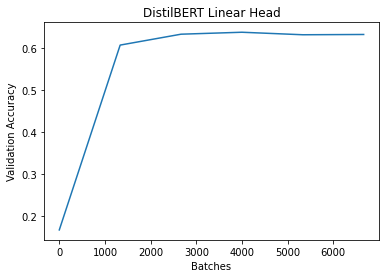

In [36]:
plt.plot(num_batches, val_accuracies)
plt.ylabel("Validation Accuracy")
plt.xlabel("Batches")
plt.title("DistilBERT Linear Head")
plt.savefig(p/"accuracy_plot.pdf")

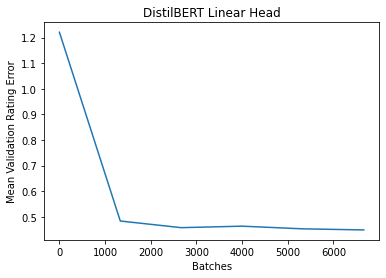

In [37]:
plt.plot(num_batches, val_errors)
plt.ylabel("Mean Validation Rating Error")
plt.xlabel("Batches")
plt.title("DistilBERT Linear Head")
plt.savefig(p/"error_plot.pdf")

In [38]:
torch.save(model.state_dict(), p/"model.pt")

In [39]:
with torch.no_grad():
    text, ratings = next(iter(val_loader))
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    logits = model(**inputs.to(device)).logits
    _, pred = torch.max(logits, 1)

In [40]:
ratings

tensor([1, 2, 0, 4, 1, 1, 0, 0, 2, 0])

In [41]:
pred

tensor([1, 3, 0, 4, 1, 0, 0, 0, 2, 0], device='cuda:0')

In [51]:
correct = 0
for text, rating in tqdm(challengedata5):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    logits = model(**inputs.to(device)).logits
    _, pred = torch.max(logits, 1)
    correct += int(pred.item() == rating)
print(correct / len(challengedata5))

  0%|          | 0/500 [00:00<?, ?it/s]

0.494


In [52]:
correct = 0
for text, rating in tqdm(challengedata8):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    logits = model(**inputs.to(device)).logits
    _, pred = torch.max(logits, 1)
    correct += int(pred.item() == rating)
print(correct / len(challengedata8))

  0%|          | 0/500 [00:00<?, ?it/s]

0.578


# exp2 -  Linear classifier and custom loss on BERT hidden state

## Load up tokenizer and model

In [21]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased').to(device)
model.classifier = nn.Sequential(
    nn.Linear(in_features=768, out_features=5, bias=True),
).to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

## Train the classifier

In [22]:
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

In [23]:
def expected_rating(logits):
    """Computes expected rating from logits \in [1, 5]"""
    probs = torch.softmax(logits, dim=1)
    return torch.matmul(probs, torch.tensor([1., 2., 3., 4., 5.]).to(device))

### Let's start with 1 epoch

In [24]:
num_batches = []
val_accuracies = []
val_losses = []
val_errors = []

In [25]:
batches = 15000

model.train()
for i, (reviews, classes) in enumerate(tqdm(islice(train_loader, batches), total=batches)): # use the term 'class' instead of 'rating' to denote that class = rating - 1
    
    if i % (batches // 50) == 0: # do 30 val acc computations
        model.eval()
        val_loss = 0
        val_accuracy = 0
        val_error = 0
        outof = 0
        with torch.no_grad():
            for reviews, classes in islice(val_loader, 200): # 200 * batch_size examples to evaluate on
                inputs = tokenizer(reviews, return_tensors="pt", padding=True, truncation=True)
                logits = model(**inputs.to(device)).logits
                _, pred = torch.max(logits, 1)
                val_accuracy += (pred == classes.to(device)).sum().item()
                val_loss += loss_fn(logits, classes.to(device))
                val_error += ((classes.to(device) + 1) - expected_rating(logits)).abs().sum()
                outof += len(classes)
        print("Val Acc: {:.2f}%".format(val_accuracy / outof * 100))
        print("Val Err: {:.2f}".format(val_error / outof))
        num_batches.append(i)
        val_accuracies.append(val_accuracy / outof)
        val_losses.append(val_loss / outof)
        val_errors.append(val_error / outof)
        model.train()
    
    optimizer.zero_grad()
    inputs = tokenizer(reviews, return_tensors="pt", padding=True, truncation=True)
    logits = model(**inputs.to(device)).logits
    loss = loss_fn(logits, classes.to(device)) * ((classes.to(device) + 1) - expected_rating(logits)).abs().sum()
    loss.backward()
    optimizer.step()
        

  0%|          | 0/15000 [00:00<?, ?it/s]

Val Acc: 20.30%
Val Err: 1.20
Val Acc: 57.10%
Val Err: 0.56
Val Acc: 60.00%
Val Err: 0.52
Val Acc: 61.00%
Val Err: 0.52
Val Acc: 61.95%
Val Err: 0.48
Val Acc: 61.00%
Val Err: 0.51
Val Acc: 63.10%
Val Err: 0.47
Val Acc: 62.00%
Val Err: 0.47
Val Acc: 61.90%
Val Err: 0.48
Val Acc: 62.70%
Val Err: 0.45
Val Acc: 63.85%
Val Err: 0.46
Val Acc: 63.75%
Val Err: 0.45
Val Acc: 60.65%
Val Err: 0.47
Val Acc: 62.10%
Val Err: 0.46
Val Acc: 62.25%
Val Err: 0.47
Val Acc: 65.95%
Val Err: 0.43
Val Acc: 64.10%
Val Err: 0.43
Val Acc: 63.10%
Val Err: 0.44
Val Acc: 64.75%
Val Err: 0.45
Val Acc: 63.50%
Val Err: 0.43
Val Acc: 61.50%
Val Err: 0.46
Val Acc: 62.10%
Val Err: 0.46
Val Acc: 63.00%
Val Err: 0.46
Val Acc: 62.75%
Val Err: 0.45
Val Acc: 61.65%
Val Err: 0.43
Val Acc: 64.60%
Val Err: 0.42
Val Acc: 63.35%
Val Err: 0.44
Val Acc: 62.65%
Val Err: 0.43
Val Acc: 65.65%
Val Err: 0.43
Val Acc: 64.70%
Val Err: 0.42
Val Acc: 65.40%
Val Err: 0.42
Val Acc: 64.80%
Val Err: 0.41
Val Acc: 65.00%
Val Err: 0.42
Val Acc: 6

In [26]:
p = pathlib.Path('exp2')
p.mkdir()

In [27]:
torch.save({
    'batches': num_batches,
    'accuracies': val_accuracies,
    'losses': val_losses,
    'errors': val_errors
}, p/"training_data.pt")

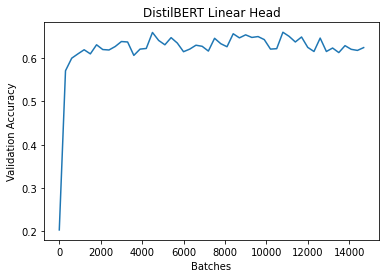

In [28]:
plt.plot(num_batches, val_accuracies)
plt.ylabel("Validation Accuracy")
plt.xlabel("Batches")
plt.title("DistilBERT Linear Head")
plt.savefig(p/"accuracy_plot.pdf")

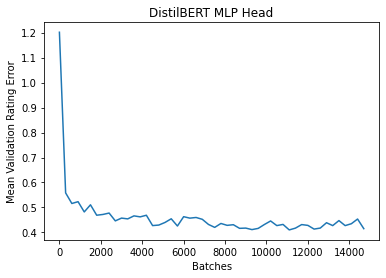

In [29]:
plt.plot(num_batches, val_errors)
plt.ylabel("Mean Validation Rating Error")
plt.xlabel("Batches")
plt.title("DistilBERT MLP Head")
plt.savefig(p/"error_plot.pdf")

In [33]:
torch.save(model.state_dict(), p/"model.pt")

In [31]:
correct = 0
for text, rating in tqdm(challengedata5):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    logits = model(**inputs.to(device)).logits
    _, pred = torch.max(logits, 1)
    correct += int(pred.item() == rating)
print(correct / len(challengedata5))

  0%|          | 0/500 [00:00<?, ?it/s]

0.454


In [32]:
correct = 0
for text, rating in tqdm(challengedata8):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    logits = model(**inputs.to(device)).logits
    _, pred = torch.max(logits, 1)
    correct += int(pred.item() == rating)
print(correct / len(challengedata8))

  0%|          | 0/500 [00:00<?, ?it/s]

0.638


# exp3 -  MLP w/ Dropout classifier on BERT hidden state

## Load up tokenizer and model

In [37]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased').to(device)
model.classifier = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(in_features=768, out_features=800, bias=True),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(in_features=800, out_features=5, bias=True)
).to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

## Train the classifier

In [38]:
optimizer = torch.optim.Adam(model.classifier.parameters())
loss_fn = nn.CrossEntropyLoss(reduction='sum')

In [39]:
def expected_rating(logits):
    """Computes expected rating from logits \in [1, 5]"""
    probs = torch.softmax(logits, dim=1)
    return torch.matmul(probs, torch.tensor([1., 2., 3., 4., 5.]).to(device))

### Let's start with 1 epoch

In [40]:
num_batches = []
val_accuracies = []
val_losses = []
val_errors = []

In [41]:
batches = 10000

model.train()
for i, (reviews, classes) in enumerate(tqdm(islice(train_loader, batches), total=batches)): # use the term 'class' instead of 'rating' to denote that class = rating - 1
    
    if i % (batches // 30) == 0: # do 30 val acc computations
        model.eval()
        val_loss = 0
        val_accuracy = 0
        val_error = 0
        outof = 0
        with torch.no_grad():
            for reviews, classes in islice(val_loader, 150): # 150 * batch_size examples to evaluate on
                inputs = tokenizer(reviews, return_tensors="pt", padding=True, truncation=True)
                logits = model(**inputs.to(device)).logits
                _, pred = torch.max(logits, 1)
                val_accuracy += (pred == classes.to(device)).sum().item()
                val_loss += loss_fn(logits, classes.to(device))
                val_error += ((classes.to(device) + 1) - expected_rating(logits)).abs().sum()
                outof += len(classes)
        print("Val Acc: {:.2f}%".format(val_accuracy / outof * 100))
        print("Val Err: {:.2f}".format(val_error / outof))
        num_batches.append(i)
        val_accuracies.append(val_accuracy / outof)
        val_losses.append(val_loss / outof)
        val_errors.append(val_error / outof)
        model.train()
    
    optimizer.zero_grad()
    inputs = tokenizer(reviews, return_tensors="pt", padding=True, truncation=True)
    logits = model(**inputs.to(device)).logits
    loss = loss_fn(logits, classes.to(device))
    loss.backward()
    optimizer.step()
        

  0%|          | 0/10000 [00:00<?, ?it/s]

Val Acc: 17.47%
Val Err: 1.21
Val Acc: 48.00%
Val Err: 0.75
Val Acc: 50.27%
Val Err: 0.71
Val Acc: 52.27%
Val Err: 0.68
Val Acc: 54.00%
Val Err: 0.65
Val Acc: 50.87%
Val Err: 0.62
Val Acc: 49.93%
Val Err: 0.71
Val Acc: 51.80%
Val Err: 0.63
Val Acc: 49.80%
Val Err: 0.68
Val Acc: 50.80%
Val Err: 0.69
Val Acc: 55.60%
Val Err: 0.62
Val Acc: 48.53%
Val Err: 0.66
Val Acc: 52.60%
Val Err: 0.65
Val Acc: 53.80%
Val Err: 0.62
Val Acc: 50.93%
Val Err: 0.64
Val Acc: 52.27%
Val Err: 0.60
Val Acc: 52.13%
Val Err: 0.66
Val Acc: 56.07%
Val Err: 0.63
Val Acc: 49.07%
Val Err: 0.67
Val Acc: 48.93%
Val Err: 0.61
Val Acc: 51.47%
Val Err: 0.61
Val Acc: 52.60%
Val Err: 0.63
Val Acc: 54.60%
Val Err: 0.62
Val Acc: 54.27%
Val Err: 0.61
Val Acc: 56.33%
Val Err: 0.61
Val Acc: 51.87%
Val Err: 0.63
Val Acc: 54.33%
Val Err: 0.61
Val Acc: 53.20%
Val Err: 0.59
Val Acc: 53.40%
Val Err: 0.61
Val Acc: 51.27%
Val Err: 0.60
Val Acc: 51.73%
Val Err: 0.64


In [42]:
p = pathlib.Path('exp3')
p.mkdir()

In [43]:
torch.save({
    'batches': num_batches,
    'accuracies': val_accuracies,
    'losses': val_losses,
    'errors': val_errors
}, p/"training_data.pt")

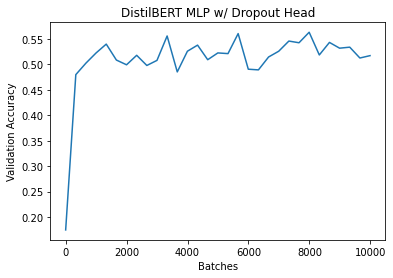

In [44]:
plt.plot(num_batches, val_accuracies)
plt.ylabel("Validation Accuracy")
plt.xlabel("Batches")
plt.title("DistilBERT MLP w/ Dropout Head")
plt.savefig(p/"accuracy_plot.pdf")

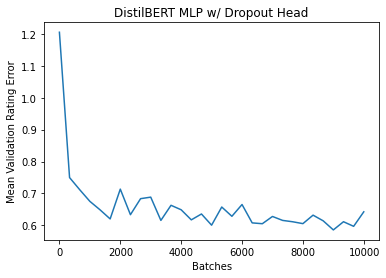

In [45]:
plt.plot(num_batches, val_errors)
plt.ylabel("Mean Validation Rating Error")
plt.xlabel("Batches")
plt.title("DistilBERT MLP w/ Dropout Head")
plt.savefig(p/"error_plot.pdf")

In [46]:
torch.save(model.classifier.state_dict(), p/"classifier.pt")

# exp4 -  linear classifier on BERT hidden state w/ distance multiple to loss

In [46]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased').to(device)
model.classifier = nn.Sequential(
    nn.Linear(in_features=768, out_features=5, bias=True),
).to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

## Train the classifier

In [47]:
optimizer = torch.optim.Adam(model.classifier.parameters())
loss_fn = nn.CrossEntropyLoss(reduction='sum')

In [48]:
def expected_rating(logits):
    """Computes expected rating from logits \in [1, 5]"""
    probs = torch.softmax(logits, dim=1)
    return torch.matmul(probs, torch.tensor([1., 2., 3., 4., 5.]).to(device))

### Let's start with 1 epoch

In [49]:
num_batches = []
val_accuracies = []
val_losses = []
val_errors = []

In [50]:
batches = 7000

model.train()
for i, (reviews, classes) in enumerate(tqdm(islice(train_loader, batches), total=batches)): # use the term 'class' instead of 'rating' to denote that class = rating - 1
    
    if i % (batches // 30) == 0: # do 30 val acc computations
        model.eval()
        val_loss = 0
        val_accuracy = 0
        val_error = 0
        outof = 0
        with torch.no_grad():
            for reviews, classes in islice(val_loader, 150): # 150 * batch_size examples to evaluate on
                inputs = tokenizer(reviews, return_tensors="pt", padding=True, truncation=True)
                logits = model(**inputs.to(device)).logits
                _, pred = torch.max(logits, 1)
                val_accuracy += (pred == classes.to(device)).sum().item()
                val_loss += loss_fn(logits, classes.to(device))
                val_error += ((classes.to(device) + 1) - expected_rating(logits)).abs().sum()
                outof += len(classes)
        print("Val Acc: {:.2f}%".format(val_accuracy / outof * 100))
        print("Val Err: {:.2f}".format(val_error / outof))
        num_batches.append(i)
        val_accuracies.append(val_accuracy / outof)
        val_losses.append(val_loss / outof)
        val_errors.append(val_error / outof)
        model.train()
    
    optimizer.zero_grad()
    inputs = tokenizer(reviews, return_tensors="pt", padding=True, truncation=True)
    logits = model(**inputs.to(device)).logits
    loss = loss_fn(logits, classes.to(device)) * ((classes.to(device) + 1) - expected_rating(logits)).abs().sum()
    loss.backward()
    optimizer.step()
        

  0%|          | 0/7000 [00:00<?, ?it/s]

Val Acc: 7.13%
Val Err: 1.67
Val Acc: 50.80%
Val Err: 1.19
Val Acc: 61.07%
Val Err: 1.00
Val Acc: 65.53%
Val Err: 0.90
Val Acc: 69.80%
Val Err: 0.87
Val Acc: 64.87%
Val Err: 0.82
Val Acc: 68.67%
Val Err: 0.77
Val Acc: 68.07%
Val Err: 0.75
Val Acc: 69.80%
Val Err: 0.74
Val Acc: 70.87%
Val Err: 0.66
Val Acc: 71.87%
Val Err: 0.66
Val Acc: 71.20%
Val Err: 0.63
Val Acc: 71.13%
Val Err: 0.66
Val Acc: 68.73%
Val Err: 0.65
Val Acc: 71.67%
Val Err: 0.63
Val Acc: 68.33%
Val Err: 0.61
Val Acc: 71.87%
Val Err: 0.61
Val Acc: 69.73%
Val Err: 0.60
Val Acc: 69.00%
Val Err: 0.63
Val Acc: 70.73%
Val Err: 0.59
Val Acc: 69.13%
Val Err: 0.57
Val Acc: 69.13%
Val Err: 0.62
Val Acc: 71.27%
Val Err: 0.59
Val Acc: 69.47%
Val Err: 0.59
Val Acc: 70.60%
Val Err: 0.59
Val Acc: 72.67%
Val Err: 0.59
Val Acc: 71.47%
Val Err: 0.54
Val Acc: 70.07%
Val Err: 0.53
Val Acc: 70.07%
Val Err: 0.56
Val Acc: 70.73%
Val Err: 0.54
Val Acc: 70.07%
Val Err: 0.53


In [51]:
p = pathlib.Path('exp4')
p.mkdir()

In [52]:
torch.save({
    'batches': num_batches,
    'accuracies': val_accuracies,
    'losses': val_losses,
    'errors': val_errors
}, p/"training_data.pt")

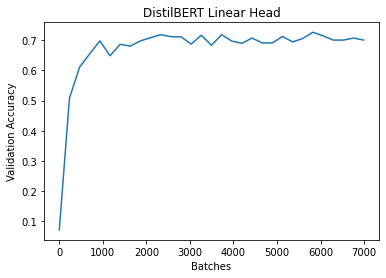

In [53]:
plt.plot(num_batches, val_accuracies)
plt.ylabel("Validation Accuracy")
plt.xlabel("Batches")
plt.title("DistilBERT Linear Head")
plt.savefig(p/"accuracy_plot.pdf")

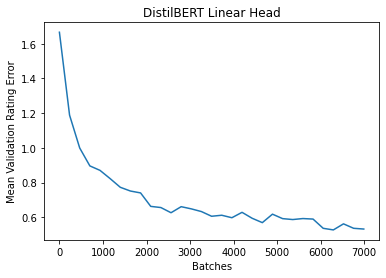

In [67]:
plt.plot(num_batches, val_errors)
plt.ylabel("Mean Validation Rating Error")
plt.xlabel("Batches")
plt.title("DistilBERT Linear Head")
plt.savefig(p/"error_plot.pdf")

In [68]:
torch.save(model.classifier.state_dict(), p/"classifier.pt")

In [11]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased').to(device)
model.classifier = nn.Sequential(
    nn.Linear(in_features=768, out_features=5, bias=True),
).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [18]:
text = "Great place! 5 stars."

In [19]:
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

In [24]:
inputs['input_ids']

tensor([[ 101, 2307, 2173,  999, 1019, 3340, 1012,  102]])

In [57]:
logits = model(**inputs.to(device)).logits

In [60]:
torch.softmax(logits, dim=1)

tensor([[0.0091, 0.0016, 0.0031, 0.0375, 0.9487]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [61]:
_, pred = torch.max(logits, 1)

In [66]:
float(pred.item())

4.0